In [1]:
# ---- Parameters ----
SCREEN = "20241118_AWALS35_intermediate_screen_n72"

In [2]:
# Parameters
SCREEN = "20241118_AWALS35_intermediate_screen_n72"


In [3]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import sys
import pandas as pd
from pathlib import Path

sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/20250916_pipelines/params")
with open(pdir / "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir / "binary-split-test.json", "r") as f:
    test_params = json.load(f)

train_params["screen"] = SCREEN
test_params["screen"] = SCREEN

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["FUS/EEA1"]
response_map = {"WT": 0, "FUS": 1}

In [4]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

assert train_screen.data is not None, "Loading failed"
assert test_screen.data is not None, "Loading failed"

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...


Preprocessing complete
Processing test set...


Preprocessing complete
Marker set: FUS/EEA1
Train data: (13218, 313)
Test data: (22825, 313)


In [5]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.n_cells = 250
dataloader_config.response_map = {"Mutations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [6]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.8684, Active: 1/1
  FUS/EEA1 - Loss: 0.8867, Acc: 0.4315 


Cell Epoch 2/100, Overall Loss: 2.5158, Active: 1/1
  FUS/EEA1 - Loss: 0.6871, Acc: 0.6355 


Cell Epoch 3/100, Overall Loss: 2.6075, Active: 1/1
  FUS/EEA1 - Loss: 0.7576, Acc: 0.5770 


Cell Epoch 4/100, Overall Loss: 2.4952, Active: 1/1
  FUS/EEA1 - Loss: 0.7240, Acc: 0.5690 


Cell Epoch 5/100, Overall Loss: 2.5516, Active: 1/1
  FUS/EEA1 - Loss: 0.6936, Acc: 0.5930 


Cell Epoch 6/100, Overall Loss: 2.5019, Active: 1/1
  FUS/EEA1 - Loss: 0.7102, Acc: 0.5670 


Cell Epoch 7/100, Overall Loss: 2.2181, Active: 1/1
  FUS/EEA1 - Loss: 0.5772, Acc: 0.6945 


Cell Epoch 8/100, Overall Loss: 2.1743, Active: 1/1
  FUS/EEA1 - Loss: 0.5840, Acc: 0.6835 


Cell Epoch 9/100, Overall Loss: 2.5911, Active: 1/1
  FUS/EEA1 - Loss: 0.7070, Acc: 0.5690 


Cell Epoch 10/100, Overall Loss: 2.2670, Active: 1/1
  FUS/EEA1 - Loss: 0.6197, Acc: 0.6390 


Cell Epoch 11/100, Overall Loss: 2.2617, Active: 1/1
  FUS/EEA1 - Loss: 0.6458, Acc: 0.6130 


Cell Epoch 12/100, Overall Loss: 2.2445, Active: 1/1
  FUS/EEA1 - Loss: 0.6390, Acc: 0.6165 


Cell Epoch 13/100, Overall Loss: 2.1111, Active: 1/1
  FUS/EEA1 - Loss: 0.5763, Acc: 0.6860 


Cell Epoch 14/100, Overall Loss: 2.0581, Active: 1/1
  FUS/EEA1 - Loss: 0.5566, Acc: 0.7140 


Cell Epoch 15/100, Overall Loss: 2.5576, Active: 1/1
  FUS/EEA1 - Loss: 0.6979, Acc: 0.5845 


Cell Epoch 16/100, Overall Loss: 2.0754, Active: 1/1
  FUS/EEA1 - Loss: 0.5718, Acc: 0.6975 


Cell Epoch 17/100, Overall Loss: 2.0837, Active: 1/1
  FUS/EEA1 - Loss: 0.5554, Acc: 0.7010 


Cell Epoch 18/100, Overall Loss: 2.2579, Active: 1/1
  FUS/EEA1 - Loss: 0.5887, Acc: 0.6885 


Cell Epoch 19/100, Overall Loss: 2.3059, Active: 1/1
  FUS/EEA1 - Loss: 0.6192, Acc: 0.6550 


Cell Epoch 20/100, Overall Loss: 2.2457, Active: 1/1
  FUS/EEA1 - Loss: 0.6091, Acc: 0.6615 


Cell Epoch 21/100, Overall Loss: 2.1173, Active: 1/1
  FUS/EEA1 - Loss: 0.5974, Acc: 0.6655 


Cell Epoch 22/100, Overall Loss: 2.1916, Active: 1/1
  FUS/EEA1 - Loss: 0.6822, Acc: 0.5950 


Cell Epoch 23/100, Overall Loss: 2.1896, Active: 1/1
  FUS/EEA1 - Loss: 0.6526, Acc: 0.6005 


Cell Epoch 24/100, Overall Loss: 2.0391, Active: 1/1
  FUS/EEA1 - Loss: 0.5536, Acc: 0.7025 


Cell Epoch 25/100, Overall Loss: 2.0725, Active: 1/1
  FUS/EEA1 - Loss: 0.5717, Acc: 0.6925 


Cell Epoch 26/100, Overall Loss: 2.0031, Active: 1/1
  FUS/EEA1 - Loss: 0.5843, Acc: 0.6770 


Cell Epoch 27/100, Overall Loss: 2.0245, Active: 1/1
  FUS/EEA1 - Loss: 0.5483, Acc: 0.7050 


Cell Epoch 28/100, Overall Loss: 2.1542, Active: 1/1
  FUS/EEA1 - Loss: 0.6525, Acc: 0.6215 


Cell Epoch 29/100, Overall Loss: 2.3753, Active: 1/1
  FUS/EEA1 - Loss: 0.6915, Acc: 0.5875 


Cell Epoch 30/100, Overall Loss: 2.4391, Active: 1/1
  FUS/EEA1 - Loss: 0.7121, Acc: 0.5745 


Cell Epoch 31/100, Overall Loss: 2.2267, Active: 1/1
  FUS/EEA1 - Loss: 0.6072, Acc: 0.6525 


Cell Epoch 32/100, Overall Loss: 2.0960, Active: 1/1
  FUS/EEA1 - Loss: 0.6082, Acc: 0.6580 


Cell Epoch 33/100, Overall Loss: 2.1111, Active: 1/1
  FUS/EEA1 - Loss: 0.5848, Acc: 0.6770 


Cell Epoch 34/100, Overall Loss: 1.8819, Active: 1/1
  FUS/EEA1 - Loss: 0.4912, Acc: 0.7745 


Cell Epoch 35/100, Overall Loss: 2.0603, Active: 1/1
  FUS/EEA1 - Loss: 0.5952, Acc: 0.6730 


Cell Epoch 36/100, Overall Loss: 1.8888, Active: 1/1
  FUS/EEA1 - Loss: 0.5047, Acc: 0.7725 


Cell Epoch 37/100, Overall Loss: 2.0012, Active: 1/1
  FUS/EEA1 - Loss: 0.5905, Acc: 0.6695 


Cell Epoch 38/100, Overall Loss: 2.2504, Active: 1/1
  FUS/EEA1 - Loss: 0.6487, Acc: 0.6260 


Cell Epoch 39/100, Overall Loss: 2.1784, Active: 1/1
  FUS/EEA1 - Loss: 0.6101, Acc: 0.6675 


Cell Epoch 40/100, Overall Loss: 1.9825, Active: 1/1
  FUS/EEA1 - Loss: 0.5867, Acc: 0.6800 


Cell Epoch 41/100, Overall Loss: 1.8645, Active: 1/1
  FUS/EEA1 - Loss: 0.4977, Acc: 0.7735 


Cell Epoch 42/100, Overall Loss: 2.0631, Active: 1/1
  FUS/EEA1 - Loss: 0.5630, Acc: 0.7170 


Cell Epoch 43/100, Overall Loss: 1.9473, Active: 1/1
  FUS/EEA1 - Loss: 0.5113, Acc: 0.7425 


  Freezing FUS/EEA1 encoder at epoch 44
Cell Epoch 44/100, Overall Loss: 2.0004, Active: 0/1
  FUS/EEA1 - Loss: 0.5945, Acc: 0.6690 [FROZEN]
All antibodies frozen - stopping cell training at epoch 44
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.7320


Line Epoch 2/100, Loss: 0.6927


Line Epoch 3/100, Loss: 0.6179


Line Epoch 4/100, Loss: 0.5510


Line Epoch 5/100, Loss: 0.6451


Line Epoch 6/100, Loss: 0.6538


Line Epoch 7/100, Loss: 0.5767


Line Epoch 8/100, Loss: 0.5248


Line Epoch 9/100, Loss: 0.5303


Line Epoch 10/100, Loss: 0.4696


Line Epoch 11/100, Loss: 0.5638


Line Epoch 12/100, Loss: 0.5147


Line Epoch 13/100, Loss: 0.5346


Line Epoch 14/100, Loss: 0.5917


Line Epoch 15/100, Loss: 0.5315


Line Epoch 16/100, Loss: 0.4791


Line Epoch 17/100, Loss: 0.4169


Line Epoch 18/100, Loss: 0.3523


Line Epoch 19/100, Loss: 0.5232


Line Epoch 20/100, Loss: 0.6493


Line Epoch 21/100, Loss: 0.4184


Line Epoch 22/100, Loss: 0.4844


Line Epoch 23/100, Loss: 0.4642


Line Epoch 24/100, Loss: 0.4535


Line Epoch 25/100, Loss: 0.5544


Line Epoch 26/100, Loss: 0.6124


Line Epoch 27/100, Loss: 0.3888


Line Epoch 28/100, Loss: 0.5151
Early stopping line training at epoch 28
Training completed!
Evaluating model...


Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.6676, Active: 1/1
  FUS/EEA1 - Loss: 0.7215, Acc: 0.5403 


Cell Epoch 2/100, Overall Loss: 2.4287, Active: 1/1
  FUS/EEA1 - Loss: 0.6904, Acc: 0.5612 


Cell Epoch 3/100, Overall Loss: 2.3755, Active: 1/1
  FUS/EEA1 - Loss: 0.6805, Acc: 0.5678 


Cell Epoch 4/100, Overall Loss: 2.2712, Active: 1/1
  FUS/EEA1 - Loss: 0.6514, Acc: 0.6137 


Cell Epoch 5/100, Overall Loss: 2.2131, Active: 1/1
  FUS/EEA1 - Loss: 0.6401, Acc: 0.6402 


Cell Epoch 6/100, Overall Loss: 2.2178, Active: 1/1
  FUS/EEA1 - Loss: 0.6618, Acc: 0.6065 


Cell Epoch 7/100, Overall Loss: 2.0984, Active: 1/1
  FUS/EEA1 - Loss: 0.6201, Acc: 0.6697 


Cell Epoch 8/100, Overall Loss: 2.0448, Active: 1/1
  FUS/EEA1 - Loss: 0.6286, Acc: 0.6543 


Cell Epoch 9/100, Overall Loss: 2.0163, Active: 1/1
  FUS/EEA1 - Loss: 0.6103, Acc: 0.6705 


Cell Epoch 10/100, Overall Loss: 1.9574, Active: 1/1
  FUS/EEA1 - Loss: 0.6180, Acc: 0.6572 


Cell Epoch 11/100, Overall Loss: 2.1260, Active: 1/1
  FUS/EEA1 - Loss: 0.6687, Acc: 0.5912 


Cell Epoch 12/100, Overall Loss: 1.9267, Active: 1/1
  FUS/EEA1 - Loss: 0.5926, Acc: 0.6895 


Cell Epoch 13/100, Overall Loss: 1.8283, Active: 1/1
  FUS/EEA1 - Loss: 0.6083, Acc: 0.6657 


Cell Epoch 14/100, Overall Loss: 2.0084, Active: 1/1
  FUS/EEA1 - Loss: 0.6266, Acc: 0.6530 


Cell Epoch 15/100, Overall Loss: 1.9954, Active: 1/1
  FUS/EEA1 - Loss: 0.6077, Acc: 0.6688 


Cell Epoch 16/100, Overall Loss: 1.8835, Active: 1/1
  FUS/EEA1 - Loss: 0.5990, Acc: 0.6838 


Cell Epoch 17/100, Overall Loss: 1.9025, Active: 1/1
  FUS/EEA1 - Loss: 0.5925, Acc: 0.6857 


Cell Epoch 18/100, Overall Loss: 1.8120, Active: 1/1
  FUS/EEA1 - Loss: 0.5917, Acc: 0.6865 


Cell Epoch 19/100, Overall Loss: 1.8648, Active: 1/1
  FUS/EEA1 - Loss: 0.6039, Acc: 0.6792 


Cell Epoch 20/100, Overall Loss: 1.8493, Active: 1/1
  FUS/EEA1 - Loss: 0.5858, Acc: 0.6905 


Cell Epoch 21/100, Overall Loss: 1.8528, Active: 1/1
  FUS/EEA1 - Loss: 0.5429, Acc: 0.7433 


Cell Epoch 22/100, Overall Loss: 1.9236, Active: 1/1
  FUS/EEA1 - Loss: 0.6392, Acc: 0.6297 


Cell Epoch 23/100, Overall Loss: 1.8892, Active: 1/1
  FUS/EEA1 - Loss: 0.6151, Acc: 0.6635 


Cell Epoch 24/100, Overall Loss: 1.7796, Active: 1/1
  FUS/EEA1 - Loss: 0.5888, Acc: 0.6868 


Cell Epoch 25/100, Overall Loss: 1.7527, Active: 1/1
  FUS/EEA1 - Loss: 0.5853, Acc: 0.6873 


Cell Epoch 26/100, Overall Loss: 1.9380, Active: 1/1
  FUS/EEA1 - Loss: 0.6138, Acc: 0.6620 


Cell Epoch 27/100, Overall Loss: 1.7454, Active: 1/1
  FUS/EEA1 - Loss: 0.5709, Acc: 0.7117 


Cell Epoch 28/100, Overall Loss: 1.7618, Active: 1/1
  FUS/EEA1 - Loss: 0.5717, Acc: 0.7047 


Cell Epoch 29/100, Overall Loss: 1.7384, Active: 1/1
  FUS/EEA1 - Loss: 0.5747, Acc: 0.7000 


Cell Epoch 30/100, Overall Loss: 1.8081, Active: 1/1
  FUS/EEA1 - Loss: 0.5807, Acc: 0.6845 


  Freezing FUS/EEA1 encoder at epoch 31
Cell Epoch 31/100, Overall Loss: 1.9750, Active: 0/1
  FUS/EEA1 - Loss: 0.6155, Acc: 0.6588 [FROZEN]
All antibodies frozen - stopping cell training at epoch 31
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.6554


Line Epoch 2/100, Loss: 0.6408


Line Epoch 3/100, Loss: 0.5151


Line Epoch 4/100, Loss: 0.5440


Line Epoch 5/100, Loss: 0.5066


Line Epoch 6/100, Loss: 0.5071


Line Epoch 7/100, Loss: 0.4135


Line Epoch 8/100, Loss: 0.4855


Line Epoch 9/100, Loss: 0.4252


Line Epoch 10/100, Loss: 0.3024


Line Epoch 11/100, Loss: 0.3278


Line Epoch 12/100, Loss: 0.3962


Line Epoch 13/100, Loss: 0.2936


Line Epoch 14/100, Loss: 0.4042


Line Epoch 15/100, Loss: 0.3493


Line Epoch 16/100, Loss: 0.2824


Line Epoch 17/100, Loss: 0.2917


Line Epoch 18/100, Loss: 0.4344


Line Epoch 19/100, Loss: 0.2992


Line Epoch 20/100, Loss: 0.3538


Line Epoch 21/100, Loss: 0.2735


Line Epoch 22/100, Loss: 0.3000


Line Epoch 23/100, Loss: 0.2381


Line Epoch 24/100, Loss: 0.3238


Line Epoch 25/100, Loss: 0.2886


Line Epoch 26/100, Loss: 0.2825


Line Epoch 27/100, Loss: 0.3933


Line Epoch 28/100, Loss: 0.2449


Line Epoch 29/100, Loss: 0.2493


Line Epoch 30/100, Loss: 0.3766


Line Epoch 31/100, Loss: 0.4244


Line Epoch 32/100, Loss: 0.1807


Line Epoch 33/100, Loss: 0.3279


Line Epoch 34/100, Loss: 0.2942


Line Epoch 35/100, Loss: 0.2174


Line Epoch 36/100, Loss: 0.3233


Line Epoch 37/100, Loss: 0.2343


Line Epoch 38/100, Loss: 0.3365


Line Epoch 39/100, Loss: 0.2448


Line Epoch 40/100, Loss: 0.2768


Line Epoch 41/100, Loss: 0.2973


Line Epoch 42/100, Loss: 0.3765
Early stopping line training at epoch 42
Training completed!
Evaluating model...


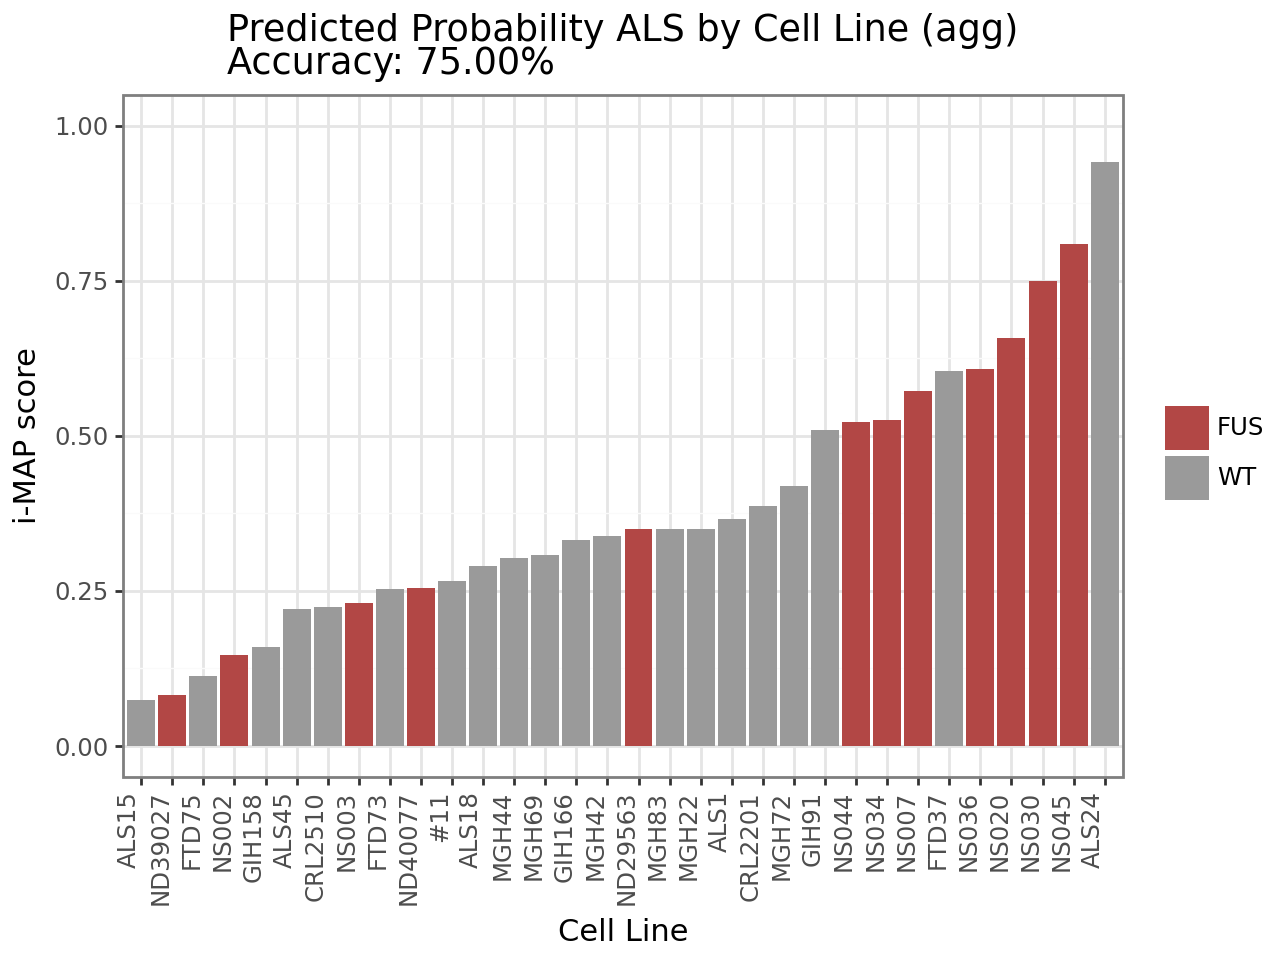

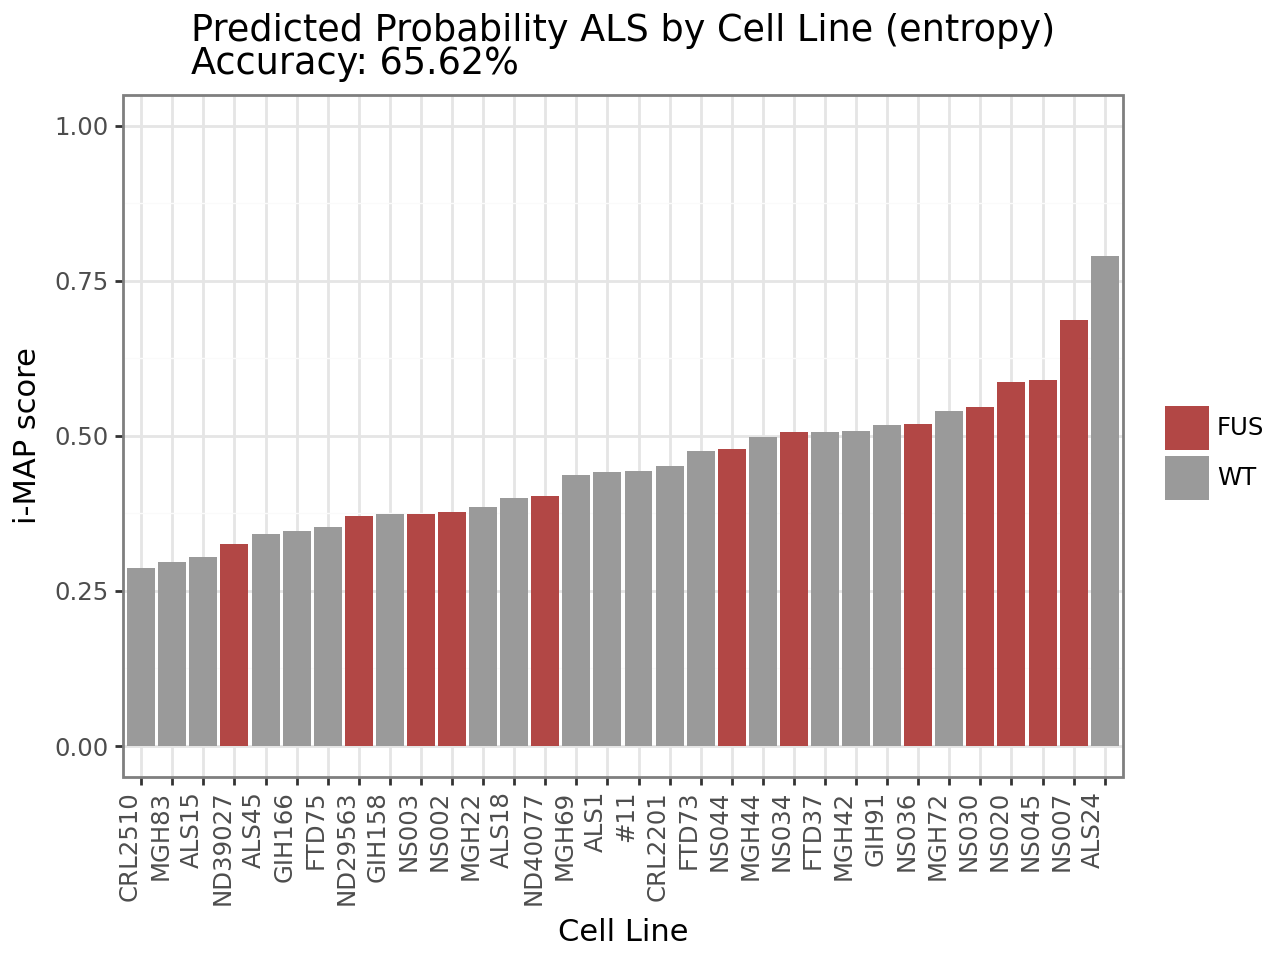

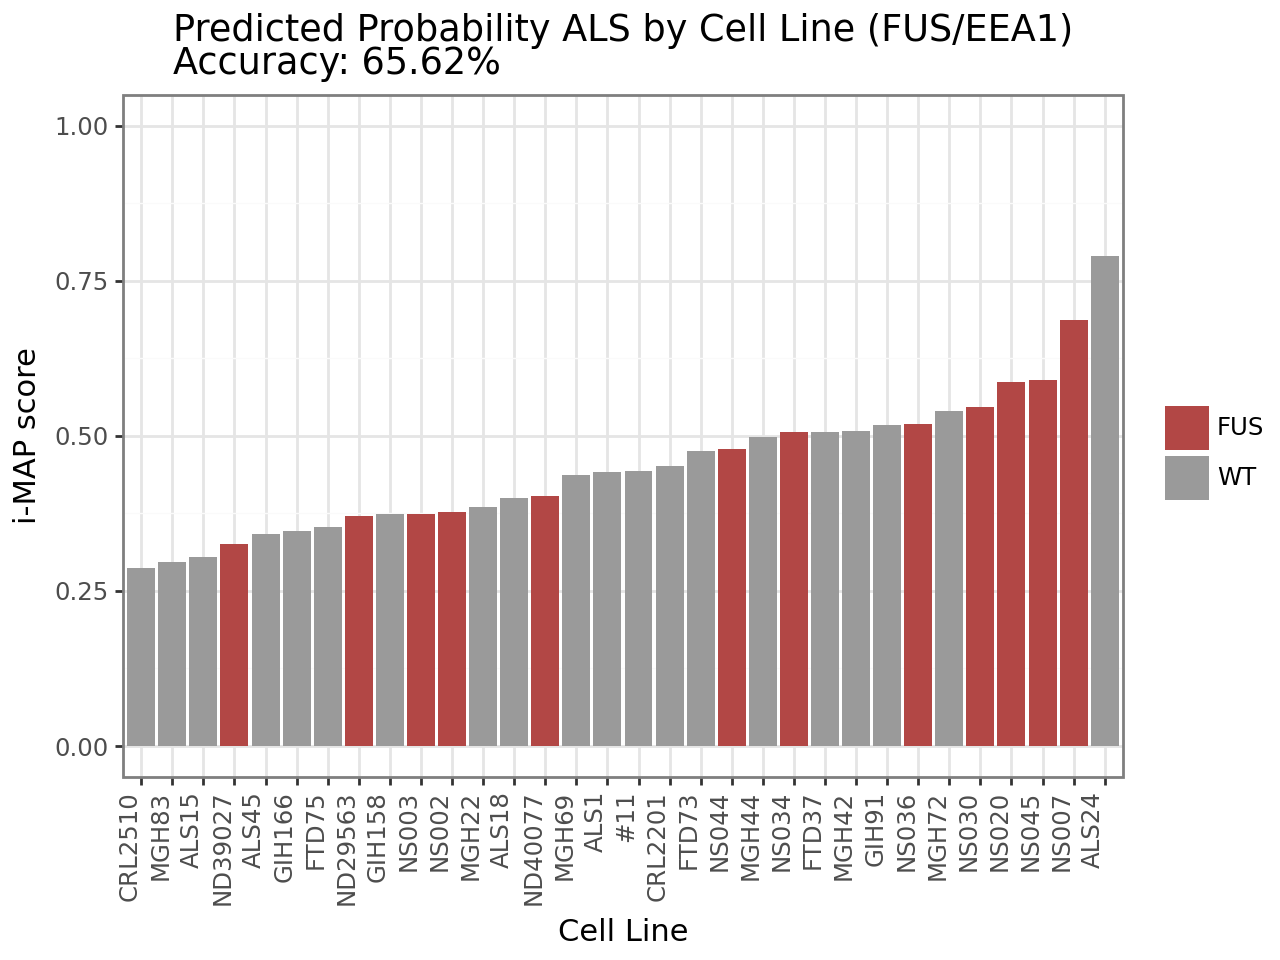

In [7]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5)
        accuracy = (pred_labels == preds["True"]).mean()
        preds["True"] = preds["True"].map({0: "WT", 1: "FUS"})
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [8]:

screen = train_params["screen"]
df["Mutation"] = df["True"].map({0: "WT", 1: "FUS"})
df = df.rename(columns={"True": "TrueClass"})
df = df.rename(columns={"class_0_agg":"prob_0", "class_1_agg":"prob_1"})
df = df[["prob_0", "prob_1", "CellLines", "TrueClass", "Mutation"]]

out_dir = Path("/home/kkumbier/als/analysis_results")
out_path = out_dir / SCREEN / f"fus_v_wt.csv"
df.to_csv(out_path, index=False)